# Multiple linear regression with Zillow data

The main focus of this project is to use linear regression methods for exploritory data analysis. The project will ultimately predict property structure values, but the more important take away is the knowledge which features hold the most predictive power. 

### Import and trim data

In this step I removed variables which were primarily missing data. Sometimes binary data will have null values instead of indicating false. In these cases, I would not want to eliminate the column because it could still be providing value. Therefore, I dropped variables which were over 90% null, were of a float data type, and had more than 10 unique values. 

The focus was to eliminate continuous variables which were missing at a high rate. There are close to 3,000,000 observations in the data set, however, I will be using 120,000 to make processing easier. However, the all methods are scalable and the quantity of observations can be adjusted. The initial threshold for eliminating variables is rather low because value can still be found in these sparse when null values are represented as a categorical value. 

The variables which I dropped, in the list named 'others' was based on a judgement call which included a variety of considerations. Generally, the variables in this list, were highly correlated with an existing variable, such as calculated number of bathrooms versus just bathroom count. I kept the richer data source in each case. I determined this by considering the number of missing values and it's correlation with the tartet variable - structure value.   

In [2]:
#import packages
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, Normalizer, OrdinalEncoder, StandardScaler, FunctionTransformer, KBinsDiscretizer, Binarizer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import statsmodels.api as sm
import category_encoders as ce
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
housing = pd.read_csv('C:/Users/erler/OneDrive/Documents/Random Data Sets/zillow/properties_2017.csv')

#get rid of duplicates (it's possible they are condos but either way it biases tree algs)
z = [x for x in list(housing.columns) if x not in ['parcelid']]
housing = housing.drop_duplicates(keep = 'first', subset=z)

#drop floats which are primarily Nan
housing = housing.drop([x for x in list(housing.columns) if 
                        housing[x].isna().sum()/len(housing) > .9 and housing[x].dtypes == float  and housing[x].dtypes == float and housing[x].nunique() > 10], axis = 1)

#remove those related to the land
land= ['propertylandusetypeid', 'lotsizesquarefeet', 'regionidcity', 'regionidneighborhood', 'censustractandblock', 
       'longitude', 'latitude', 'regionidcounty','regionidzip', 'rawcensustractandblock', 'propertycountylandusecode',
                        'propertyzoningdesc', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']

#Get rid of farms and other extremes (used for different analysis)
housing = housing.drop(housing.loc[housing['finishedsquarefeet12']>10000].index).reset_index(drop=True)
housing = housing.drop(housing.loc[housing['structuretaxvaluedollarcnt']>10000000].index).reset_index(drop=True)
housing = housing.drop(housing.loc[housing['lotsizesquarefeet']>3000000].index).reset_index(drop=True)
housing = housing.drop(housing.loc[housing['landtaxvaluedollarcnt']<2000].index).reset_index(drop=True)

#Remove all observations which have null values for the following variables
housing=housing.dropna(subset=['landtaxvaluedollarcnt', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt'])
#Drop variables which relate to the land
housing = housing.drop(land, axis = 1)
#Determine quantity of observations to use
housing= housing.iloc[:100000,:].reset_index(drop=True)
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

I found that solving for collinearity must be approached at two phases when using a model with one hot encoding. The first phase is to choose between features that inherently are representing the same concept. For example, the number of full bathrooms and the total number of bathrooms (full or not full). This type of collinearity needs to be addressed manually. The second phase of collinearity is more coinceidental. In these cases, collinearity is present but is less of a result of duplicate features. For example, when a structure has 10 or more bedrooms it may be becuase it is an apartment building in which case the feature for 10+ bedrooms will have a high correlation with 7+ garage stalls. When the correlation is higher than .7, one of these features needs to be removed, however, unlike the type of relationship described previously, it's overkill to remove all features derived from the one-hot encoded garage stall count features.

The first phase of addressing collinearity will take place prior to one-hot encoding in the preprocess pipeline and the second phase will take place afterwards. In this first phase I am target encoding all non-continuous variables to more easily calculate correlation among the variables. After which, I will rank pairs of variables by collinearity and along with each variable's correlation with the target variable. Lastly, I will consider the number of missing values for each variable. This information will allow me to decide which variables to keep. For example, 'fullbathcnt', 'bathroomcnt', and 'calculatedbathnbr' are have a correlation of about .95, which means I will only keep one. They all have correlations with the target variable of around .6. However, 'bathroomcnt' has no missing values, while the others are missing around 1.5% of the values. Therefore, I will retain only 'bathroomcnt'. 

In [4]:
#get variables to target encode
objectcols = list(set(list(housing.loc[train_set.index,housing.loc[train_set.index].nunique() < 300].columns) + list(housing.loc[train_set.index].select_dtypes(exclude=[np.number]))))

#perform target encoding
target_enc = ce.TargetEncoder(cols=objectcols, handle_missing='return_nan')
target_enc.fit(train_set[objectcols], train_set['structuretaxvaluedollarcnt'])
target_enc.transform(train_set[objectcols])
x=train_set[objectcols]
x2 = target_enc.transform(x)
objectcols.append('structuretaxvaluedollarcnt') 
train_set = train_set.drop(objectcols,axis=1)
collinearitydf = train_set.join(x2, how='left')
pd.set_option('display.max_columns', None)
collinearitydf.head(5)

,parcelid,calculatedfinishedsquarefeet,finishedsquarefeet12,garagetotalsqft,typeconstructiontypeid,threequarterbathnbr,heatingorsystemtypeid,storytypeid,bedroomcnt,fullbathcnt,fireplacecnt,architecturalstyletypeid,bathroomcnt,hashottuborspa,buildingqualitytypeid,roomcnt,taxdelinquencyflag,fireplaceflag,numberofstories,assessmentyear,unitcnt,calculatedbathnbr,buildingclasstypeid,airconditioningtypeid,poolcnt,pooltypeid10,pooltypeid2,yearbuilt,fips,garagecarcnt,decktypeid,pooltypeid7
75220,12609064,2100.0,2100.0,NaN,NaN,NaN,212948.450174,NaN,211866.384626,226890.825959,NaN,NaN,218978.894432,NaN,177092.534636,181882.174263,NaN,NaN,NaN,175184.086617,169354.767091,218978.894432,NaN,NaN,NaN,NaN,NaN,136587.176085,170151.464887,NaN,NaN,NaN
48955,12794978,1597.0,1597.0,NaN,NaN,NaN,95566.300355,NaN,141990.877345,131491.600473,NaN,NaN,123597.053645,NaN,123710.587472,181882.174263,NaN,NaN,NaN,175184.086617,169354.767091,123597.053645,NaN,NaN,NaN,NaN,NaN,126907.168434,170151.464887,NaN,NaN,NaN
44966,11772323,2472.0,NaN,NaN,NaN,NaN,NaN,NaN,376713.987324,620878.356339,NaN,NaN,571708.350785,NaN,93752.384674,181882.174263,NaN,NaN,NaN,175184.086617,139345.528538,571708.350785,NaN,NaN,NaN,NaN,NaN,142273.582862,170151.464887,NaN,NaN,NaN
13568,17066127,1056.0,1056.0,256.0,NaN,NaN,NaN,NaN,113379.437029,75921.383705,NaN,NaN,75596.469291,NaN,NaN,107510.086505,NaN,NaN,130301.271419,175184.086617,NaN,75598.825968,NaN,NaN,NaN,NaN,NaN,117340.301907,202155.114645,100384.666151,NaN,NaN
92727,14346971,2870.0,2870.0,701.0,NaN,258372.838381,NaN,NaN,141990.877345,131491.600473,NaN,NaN,192786.684812,NaN,NaN,190475.260807,NaN,NaN,201202.959484,175184.086617,NaN,192551.240945,NaN,205043.46435,NaN,NaN,NaN,201203.028770,183778.582786,189770.815502,NaN,NaN


In [6]:
#the code below will cycle through the correlations removing a one variable from collinear pairs 
#until all pairs are below a .7 pearson correlation
df = collinearitydf
corr_table = pd.DataFrame([1], columns=['r']) 
table = []
for i in df.columns:
    for j in df.columns:
        if i != j: #prevent same variable pairs
            if [j, i] not in [x[:2] for x in table]: #prevent duplicate pairs
                table.append([i, j, abs(df[i].corr(df[j])), abs(housing.loc[train_set.index]['structuretaxvaluedollarcnt'].corr(df[i]))
                              , abs(housing.loc[train_set.index]['structuretaxvaluedollarcnt'].corr(df[j])), housing.loc[train_set.index][i].isna().sum()/len(housing.loc[train_set.index])*100, 
                              housing.loc[train_set.index][j].isna().sum()/len(housing.loc[train_set.index])*100])
                
#create table for easier analysis                
corr_table = pd.DataFrame(table, columns=['v1', 'v2', 'r', 'v1 r_target', 'v2 r_target', 'v1 NA%','v2 NA%' ]).sort_values(by='r', ascending = False).reset_index(drop=True) 
corr_table = corr_table.style.format({'r':'{:.2f}', 'v1 r_target':'{:.2f}', 'v2 r_target':'{:.2f}', 'v1 NA%':'{:.2f}%', 'v2 NA%': '{:.2f}%'})
corr_table

,v1,v2,r,v1 r_target,v2 r_target,v1 NA%,v2 NA%
0,decktypeid,pooltypeid7,1.00,nan,0.00,99.42%,81.73%
1,storytypeid,fips,1.00,0.00,0.05,99.94%,0.00%
2,typeconstructiontypeid,pooltypeid7,1.00,0.00,0.00,99.91%,81.73%
3,fireplaceflag,assessmentyear,1.00,0.00,0.03,99.91%,0.00%
4,fireplaceflag,fips,1.00,0.00,0.05,99.91%,0.00%
5,poolcnt,pooltypeid7,1.00,0.00,0.00,80.55%,81.73%
6,heatingorsystemtypeid,fireplaceflag,1.00,0.28,0.00,32.97%,99.91%
7,poolcnt,decktypeid,1.00,0.00,nan,80.55%,99.42%
8,calculatedfinishedsquarefeet,finishedsquarefeet12,1.00,0.64,0.74,0.18%,7.98%
9,storytypeid,assessmentyear,1.00,0.00,0.03,99.94%,0.00%


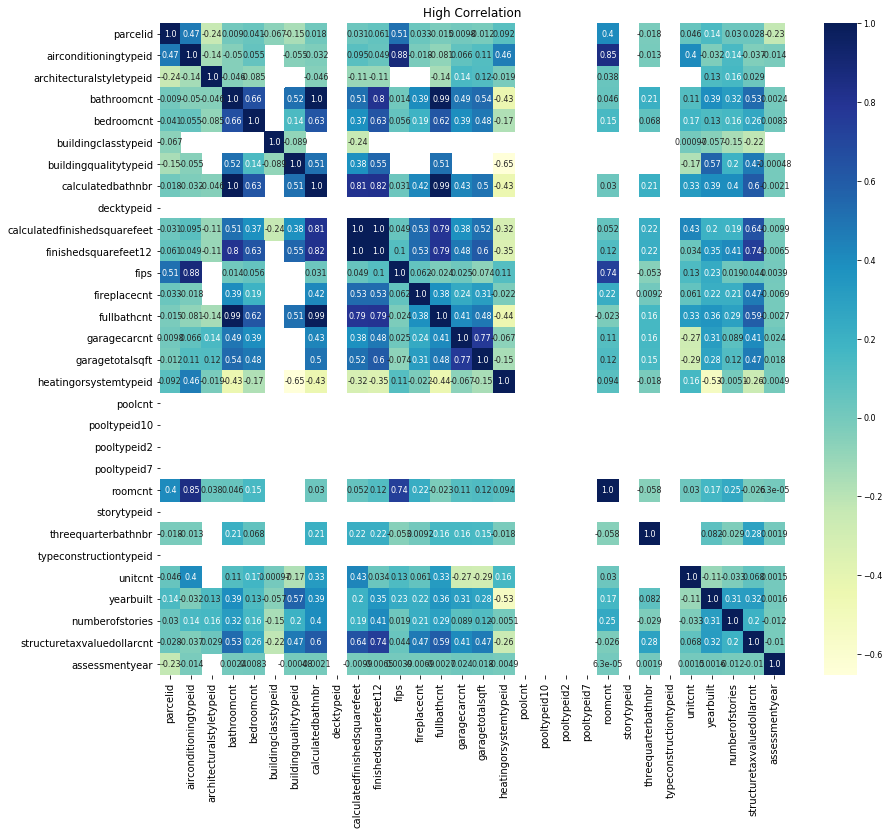

In [7]:
#This view is of the data prior to preprocessing
num_correlation = housing.loc[train_set.index].corr(method='pearson')
plt.figure(figsize=(14,12))
plt.title('High Correlation')
plt.rc('font', size=8) 
sns.heatmap(data=num_correlation, cmap="YlGnBu", annot=True, fmt=".2")

The table below allows me to understand the target value and volume for each unique value of a variable. This helps me to determine whether a variable should be recieve an upper limit when the data becomes sparse but have drastically different target values than the majority of the data. I observed this with variables such as room count.  

In [10]:
x = housing.loc[train_set.index]
table = pd.DataFrame([], columns=['feature', 'unique_val', 'mean', 'proportion'])
#table = []
try:
    objectcols.remove('structuretaxvaluedollarcnt')
except:
    pass 
for i in x[objectcols]:
    x[i] = x[i].astype(str)
    grouped = pd.DataFrame(x.groupby([i]).agg(
        price_year= pd.NamedAgg(column='structuretaxvaluedollarcnt', aggfunc= 'mean'),
        count_year= pd.NamedAgg(column='structuretaxvaluedollarcnt', aggfunc='count')
        )).reset_index()
    grouped['feature'] = i 
    grouped.columns = ['unique_val', 'mean', 'proportion', 'feature']
    grouped = grouped[['feature', 'unique_val', 'mean', 'proportion']]
    try:
        table['unique_val'] = table['unique_val'].astype(float)
    except:
        pass
    table = pd.concat([table, grouped]).reset_index(drop=True).sort_values(['feature', 'unique_val'])
pd.set_option('display.max_rows', 500)  
#pd.options.display.float_format = "{:2,.2f}".format
table['proportion'] = table['proportion']/len(x)*100
table = table.style.format({'unique_val':'{:}', 'mean': '{0:,.2f}', 'proportion': '{:.3f}%'})
table

,feature,unique_val,mean,proportion
0,airconditioningtypeid,1.0,"238,033.87",26.136%
1,airconditioningtypeid,11.0,"95,323.92",0.033%
2,airconditioningtypeid,12.0,"69,181.00",0.003%
3,airconditioningtypeid,13.0,"205,043.46",2.086%
4,airconditioningtypeid,5.0,"118,887.87",0.286%
5,airconditioningtypeid,9.0,"294,292.41",0.086%
6,airconditioningtypeid,nan,"151,603.50",71.370%
7,architecturalstyletypeid,2.0,"76,443.00",0.001%
8,architecturalstyletypeid,7.0,"103,033.31",0.076%
9,architecturalstyletypeid,8.0,"109,720.67",0.004%


I like to use the histograms to quickly spot variables that are numeric but are actually category types. Continuous and oridinal variables are generally easy to distinguish as well.  

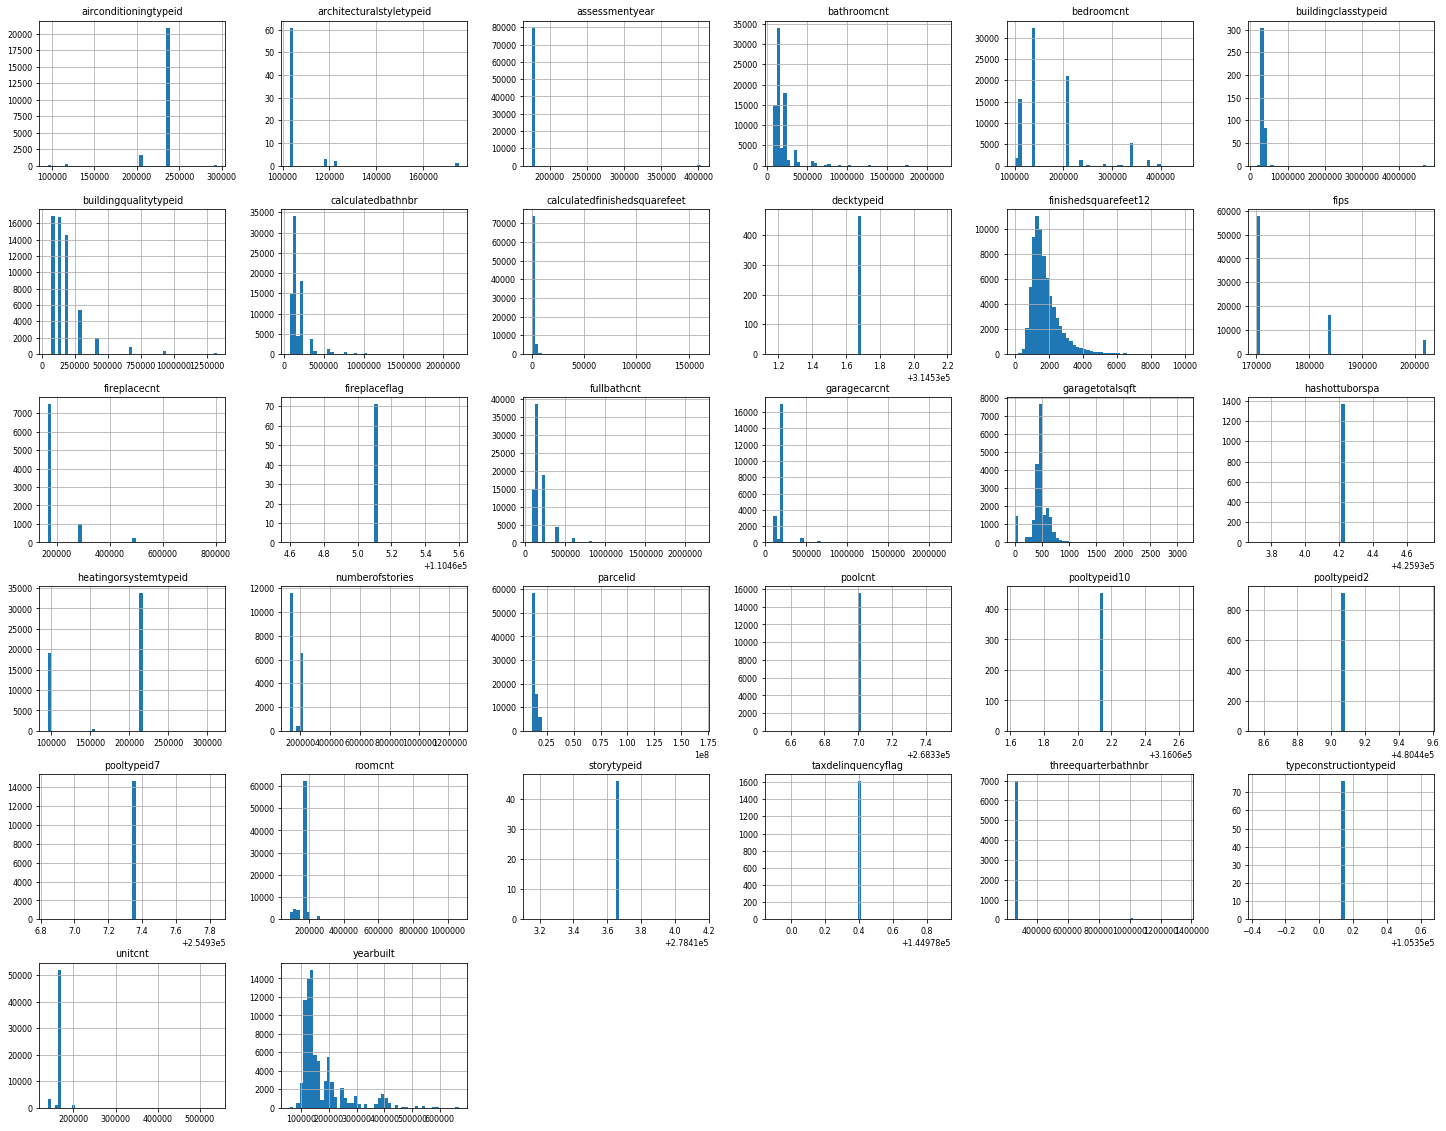

In [7]:
collinearitydf.hist(bins=50, figsize=(25,20))
plt.show()

## Eliminate collinear variables and feature engineering: Before one-hot encoding

Based on all the information above, below is a list of changes made to the data prior to preprocessing

Parcelid - these are unique for each observation so it doesn't add value
calculatedfinishedsquarefeet - This is 100% correlated with finishedsquarefeet12 but has 10% more missing values and -10% signal
calculatedbathnbr and fullbathcnt - These are eliminated becuase they have missing values while bathroomcnt does not.
fireplaceflag - 99.9% missing and 100% correlated with 3 other variables. No correlation with target variable.
storytypeid - 99.9% missing
roomcnt - 72% of all observations had a zero rooms which is means this feature is simply innaccurate. According to the data dictionary provided by zillow, this variable is supposed to be total number of rooms. Likewise there was a -.02 correlation with the target variable, meaning it wasn't likely providing value.
garagetotalsqft - Highly correlated with garagecarcnt, and garagecarcnt had a slightly better correlation with target variable
bathroomcnt - This has a .8 correlation with finishedsquarefeet12 and sadly must be removed
decktypeid - 99.4% missing values
fips - many missing values and not much value
taxdelinquencyflag - Many missing values

poolcnt, pooltypeid10, 'pooltypeid2, pooltypeid7 - These feature were very sparse, so I created a boolean variable that was true if any of those variable were not missing. Then deleted the original variables. 

In [8]:
others = ['parcelid', 'calculatedfinishedsquarefeet','fireplaceflag', 'calculatedbathnbr', 'fullbathcnt', 
          'roomcnt', 'garagetotalsqft', 'assessmentyear', 'numberofstories', 'fips', 'taxdelinquencyflag', 'buildingqualitytypeid']
housing = housing.drop(others, axis=1)

#combine pool features
pools = ['poolcnt', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7']
housing['no_pool']= housing[pools].isna().apply(lambda x: all(x), axis=1)
housing['no_pool']=housing['no_pool']*1
housing = housing.drop(pools, axis=1)

#there are a sparse number of units above 6 and many have very high values. So max set to 6+
housing.unitcnt.iloc[housing['unitcnt'].loc[housing['unitcnt']>=6].index]='6+'
#there are a sparse number of bedrooms 10 or above. So max set to 10+
housing.bedroomcnt.iloc[housing['bedroomcnt'].loc[housing['bedroomcnt']>=10].index]='10+'
#there are a sparse number of bathrooms at 6.5+ or above. So max set to 6.5+
housing.bathroomcnt.iloc[housing['bathroomcnt'].loc[housing['bathroomcnt']>=6.5].index]='6.5+'
#there are a sparse number of garages at 7+ or above. So max set to 7+
housing.garagecarcnt.iloc[housing['garagecarcnt'].loc[housing['garagecarcnt']>=7].index]='7+'

# Preprocess data in pipeline

This section concerns preprocessing transformations which will set the stage for optimized machine learning. For more information on my theory on preprocessing, see the document[]. Basically, I need to impute for missing values, address skewed data, scale data equally, and determine categorical data and treat for high cardinality (many unique values, think zip codes).  

The approach below using pipelines in order to make a scalable solution. The first step is was to determine the ideal treatments for each variable. This process, is not explored in this notebook, but involved examining the relationship of each variable with the target variable, structure price. I also examined the distribution of the values for each variable. This also included, reducing the number of categories in cases where sparse data could cause high variance which could lead to inaccurate predictions in new data. 

Many aspects of this process can be automated by viewing the data type, the number of unique values relative to total observations, and distribution. However, I needed to review the data descriptions often which were provided by zillow  inlcuded in the data to make the right calls in how the data needs to be treated. Therefore, this process can be quite manual and domain knowledge of the data set shouldn't be overlooked. 

Tactically, I primarly used common preset transformers found in the scikit package, however, I needed to create one customized transformer to reduce cardinality for the year the house was built. 

In [9]:
#split data into respective data groupings for the needed transformations
cat_attribs = list(set(list(housing.loc[:,housing.nunique() < 300].columns) + list(housing.select_dtypes(exclude=[np.number]))))
num_attribs = [x for x in list(housing.columns) if x not in cat_attribs]

#convert string to number
#housing.hashottuborspa.loc[housing.hashottuborspa =='True'] = 1

X = housing.drop('structuretaxvaluedollarcnt', axis=1) # drop labels for training set
y = housing['structuretaxvaluedollarcnt'].copy()

#Assign variable groupings for preprocessing activities
ord_attribs= [] #ordinal variables      
binned_cats = ['yearbuilt'] #bin before one-hot encoding
cat_attribs = list(set([x for x in cat_attribs if x not in binned_cats and x not in ord_attribs])) #for variables to be one-hot encoded
num_attribs = [x for x in num_attribs if x not in cat_attribs and x not in ord_attribs]

#cat_to_bin
bin_attribs = ['hashottuborspa', 'airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'fireplacecnt', 'decktypeid']
cat_attribs = [x for x in cat_attribs if x not in bin_attribs]

for i in cat_attribs:
    X[i] = X[i].astype(str)
    
try:
    num_attribs.remove('structuretaxvaluedollarcnt')
except:
    pass

#custom transformers
class KbinsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bins, fillval, encode, strategy):
        self.bins = bins
        self.fillval = fillval
        self.encode = encode
        self.strategy = strategy
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        #print('\>>>>>>>fit() called.\n')
        X_ = X.copy()
        X_ = X_.astype('float')
        bin_imputer = SimpleImputer(strategy='constant', fill_value = self.fillval)
        disc = KBinsDiscretizer(n_bins=self.bins, encode=self.encode, strategy=self.strategy)
        X_ = pd.DataFrame(bin_imputer.fit_transform(X_.values.reshape(-1, 1)))
        X_ = disc.fit_transform(X_.values.reshape(-1, 1))
        return X_

#preprocessing pipeline 2
num_pipeline = Pipeline([
        ('num_imputer', SimpleImputer(strategy="median")),
        ('MinMaxScaler', MinMaxScaler()),
    ])

#transformations for categorical variables
cat_pipeline = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ])

#transformations for categorical variables with cardinality reduction (year built) 
binned_cat_pipeline = Pipeline([
    ('kbins', KbinsTransformer(bins = 15, fillval= housing.yearbuilt.median(), encode='ordinal', strategy='quantile')),
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ])

#transformations for binary variables
bin_pipeline = Pipeline([
    ('bin_imputer', SimpleImputer(strategy='constant', fill_value = 0.111)),
    ('binarizar', Binarizer(threshold=0.111)),
    ])

#transformations for ordinal variables
ord_pipeline = Pipeline([
    ('ord_imputer', SimpleImputer(strategy='most_frequent')),
    ('ord_enc', OrdinalEncoder()),
    ('MinMaxScaler', MinMaxScaler()),
    ])

#Combine pipelines for the various preprocessing groups and transformation assignments 
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
        ("kbin_cat", binned_cat_pipeline, binned_cats),
        ('bin', bin_pipeline, bin_attribs),
        ("ord", ord_pipeline, ord_attribs),   
    ])

#train model data
data_prepared = full_pipeline.fit_transform(X)

#reintroduce y values
data = pd.DataFrame(data_prepared.toarray())
data.columns = list(num_attribs)+list(full_pipeline.transformers_[1][1].named_steps['ohe'].get_feature_names(cat_attribs))+list(full_pipeline.transformers_[2][1].named_steps['ohe'].get_feature_names(binned_cats))+list(bin_attribs)+list(ord_attribs)
data_prepared = pd.concat([data, y.reset_index(drop=True)], axis= 1)

#training set
training = data_prepared.loc[train_set.index].drop('structuretaxvaluedollarcnt', axis=1) # drop labels for training set
training_labels = data_prepared.loc[train_set.index]['structuretaxvaluedollarcnt']

#test set
testing = data_prepared.loc[test_set.index].drop('structuretaxvaluedollarcnt', axis=1) # drop labels for training set
testing_labels = data_prepared.loc[test_set.index]['structuretaxvaluedollarcnt']

In [10]:
pd.set_option('display.max_columns', None)
print(training.shape)
training.head()

(80000, 80)


,finishedsquarefeet12,heatingorsystemtypeid_1.0,heatingorsystemtypeid_13.0,heatingorsystemtypeid_18.0,heatingorsystemtypeid_2.0,heatingorsystemtypeid_20.0,heatingorsystemtypeid_6.0,heatingorsystemtypeid_7.0,heatingorsystemtypeid_nan,no_pool_0,no_pool_1,garagecarcnt_0.0,garagecarcnt_1.0,garagecarcnt_2.0,garagecarcnt_3.0,garagecarcnt_4.0,garagecarcnt_5.0,garagecarcnt_6.0,garagecarcnt_7+,garagecarcnt_nan,bathroomcnt_0.0,bathroomcnt_1.0,bathroomcnt_1.5,bathroomcnt_2.0,bathroomcnt_2.5,bathroomcnt_3.0,bathroomcnt_3.5,bathroomcnt_4.0,bathroomcnt_4.5,bathroomcnt_5.0,bathroomcnt_5.5,bathroomcnt_6.0,bathroomcnt_6.5+,typeconstructiontypeid_6.0,typeconstructiontypeid_nan,bedroomcnt_0.0,bedroomcnt_1.0,bedroomcnt_10+,bedroomcnt_2.0,bedroomcnt_3.0,bedroomcnt_4.0,bedroomcnt_5.0,bedroomcnt_6.0,bedroomcnt_7.0,bedroomcnt_8.0,bedroomcnt_9.0,unitcnt_1.0,unitcnt_2.0,unitcnt_3.0,unitcnt_4.0,unitcnt_5.0,unitcnt_6+,unitcnt_nan,storytypeid_7.0,storytypeid_nan,threequarterbathnbr_1.0,threequarterbathnbr_2.0,threequarterbathnbr_3.0,threequarterbathnbr_nan,yearbuilt_0.0,yearbuilt_1.0,yearbuilt_2.0,yearbuilt_3.0,yearbuilt_4.0,yearbuilt_5.0,yearbuilt_6.0,yearbuilt_7.0,yearbuilt_8.0,yearbuilt_9.0,yearbuilt_10.0,yearbuilt_11.0,yearbuilt_12.0,yearbuilt_13.0,yearbuilt_14.0,hashottuborspa,airconditioningtypeid,architecturalstyletypeid,buildingclasstypeid,fireplacecnt,decktypeid
75220,0.210321,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48955,0.159920,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44966,0.157214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13568,0.105711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92727,0.287475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Variable smoothing with ordinal variables  

In the variable “year built”, I viewed the mean structure value plotted against the year built. I noticed that although there was a strong trend in the data, certain years, especially in older homes with less observations, the mean structure value fluctuated greatly due to the influence of outliers as shown in figure 1 below. To address this issue, I grouped the variable “year built” into 15 clusters using Scikit Learn’s KBinsDiscretizer with the encoding setting as ordinal and the strategy setting set to quantile. Below is a visual of the transformation from individuals years to 15 sequential clusters.

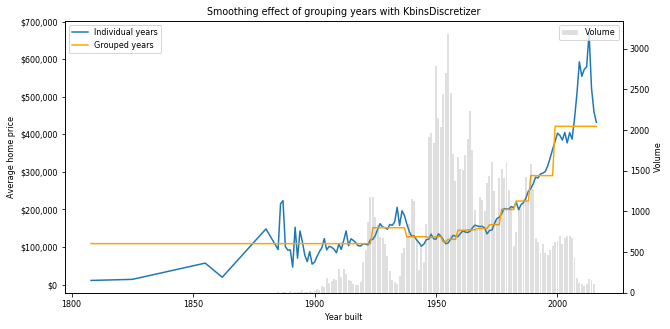

In [11]:
import matplotlib.ticker as ticker
housing2 = housing[['yearbuilt', 'structuretaxvaluedollarcnt']]

#strategy{‘uniform’, ‘quantile’, ‘kmeans’}, (default=’quantile’)
binned_cat_pipeline = Pipeline([
    ('kbins', KbinsTransformer(bins = 15, fillval= housing.yearbuilt.median(), encode='ordinal', strategy='quantile')),
    ])

pre_pipeline = ColumnTransformer([
    ("kbin_cat", binned_cat_pipeline, binned_cats), 
    ])

housing2['k_years'] = pre_pipeline.fit_transform(housing)

import matplotlib.ticker as mtick
grouped = pd.DataFrame(housing2.groupby(['yearbuilt', 'k_years']).agg(
    price_year= pd.NamedAgg(column='structuretaxvaluedollarcnt', aggfunc= 'mean'),
    count_year= pd.NamedAgg(column='structuretaxvaluedollarcnt', aggfunc='count')
    )).reset_index()

df = pd.DataFrame(housing2.groupby('k_years')['structuretaxvaluedollarcnt'].mean()).reset_index()
grouped = grouped.merge(df,left_on='k_years', right_on='k_years')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
grouped.plot(x='yearbuilt', y='price_year', ax=ax, label = 'Individual years')
grouped.plot(x='yearbuilt', y='structuretaxvaluedollarcnt', ax=ax, label = 'Grouped years', color = 'orange')
#grouped['count_year'].plot(x='yearbuilt', y='count_year', ax=ax, label = 'Volume years')

ax2 = ax.twinx()
ax2.set_ylabel('Volume')
ax2.bar(grouped['yearbuilt'], grouped['count_year'], color='grey', alpha=.25, label = 'Volume')
ax2.tick_params(axis='y')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)
plt.legend()
ax.set_xlabel('Year built')
ax.set_ylabel('Average home price', )
plt.title('Smoothing effect of grouping years with KbinsDiscretizer')
plt.show()
#plt.savefig('structure_year_blend.png')

# Search for Collinearity: After one-hot encoding 

The next step is to scan for independent variables which have high correlations with one another, or collinearity. When one independent variable is highly correlated with another independent variable the marginal contribution of that independent variable is diminished by the other independent variables. This leads to regression coefficients and their significance tests being unreliable.

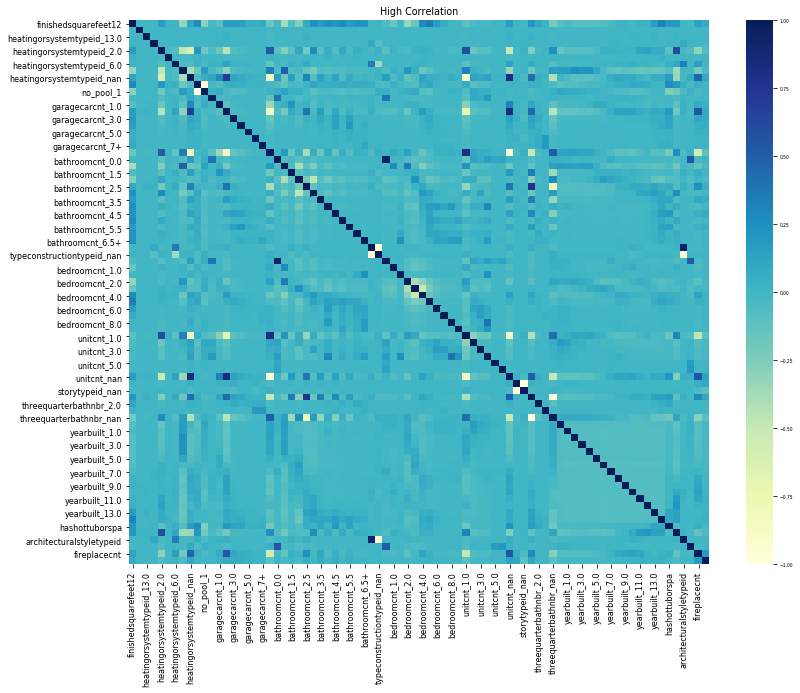

In [12]:
#We can see that some collinearity is present
num_correlation = training.corr(method='pearson')
plt.figure(figsize=(13,10))
plt.title('High Correlation')
plt.rc('font', size=4.5) 
sns.heatmap(data=num_correlation, annot=False, cmap="YlGnBu")

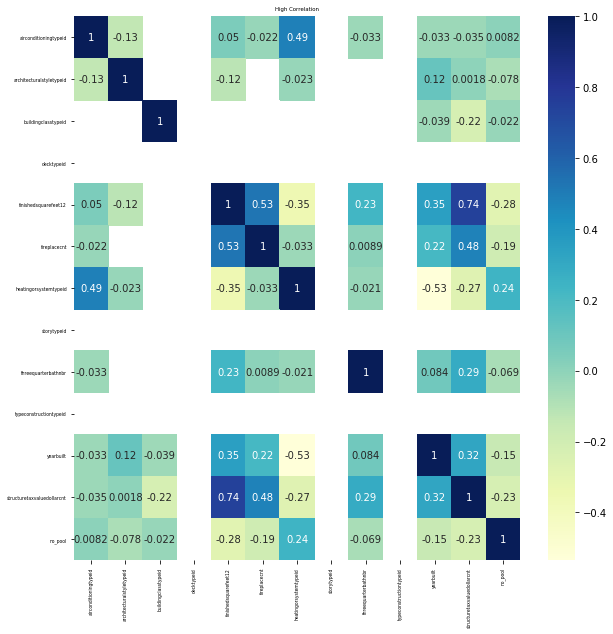

In [13]:
#This view is of the data prior to preprocessing
num_correlation = housing.corr(method='pearson')
plt.figure(figsize=(10,10))
plt.title('High Correlation')
plt.rc('font', size=10) 
sns.heatmap(data=num_correlation, annot=True, cmap="YlGnBu")

The code below will cycle through the correlations removing a one variable from collinear pairs 
until all pairs are below a .7 pearson correlation.

In [14]:
#the code below will cycle through the correlations removing a one variable from collinear pairs 
#until all pairs are below a .7 pearson correlation
dropped = []
C = .7 #max collinearity
corr_table = pd.DataFrame([1], columns=['r']) #little trick to establish starting max in corr_table
while corr_table.r.max() > C:    
    table = []
    for i in training.columns:
        for j in training.columns:
            if i != j: #prevent same variable pairs
                if [j, i] not in [x[:2] for x in table]: #prevent duplicate pairs
                    table.append([i, j, abs(np.corrcoef(training[j], training[i])[0,1])])
    #create table for easier analysis                
    corr_table = pd.DataFrame(table, columns=['v1', 'v2', 'r']).sort_values(by='r', ascending = False).reset_index(drop=True) 
    #Drop one partner of variable pairs which have a correlation above max level
    collinearity_list = list(set([x for x in list(corr_table.v1.loc[corr_table.r>C]) if x not in list(corr_table.v2.loc[corr_table.r>C])]))
    dropped.append(collinearity_list)
    training = training.drop(collinearity_list, axis=1)
    testing = testing.drop(collinearity_list, axis=1)

In [15]:
#after removing collinear variables
print(dropped) #list of variables dropped on each cycle
print(training.shape)
corr_table.head(15)

[['storytypeid_7.0', 'heatingorsystemtypeid_nan', 'bathroomcnt_2.5', 'no_pool_0', 'bathroomcnt_0.0', 'typeconstructiontypeid_6.0'], ['garagecarcnt_2.0', 'typeconstructiontypeid_nan', 'threequarterbathnbr_1.0'], ['garagecarcnt_nan'], ['unitcnt_1.0'], []]
(80000, 69)


,v1,v2,r
0,heatingorsystemtypeid_2.0,airconditioningtypeid,0.606186
1,unitcnt_nan,fireplacecnt,0.562141
2,heatingorsystemtypeid_2.0,unitcnt_nan,0.523458
3,bedroomcnt_0.0,buildingclasstypeid,0.522757
4,unitcnt_nan,threequarterbathnbr_nan,0.501250
5,heatingorsystemtypeid_7.0,bathroomcnt_1.0,0.496238
6,bedroomcnt_3.0,bedroomcnt_4.0,0.492778
7,heatingorsystemtypeid_2.0,heatingorsystemtypeid_7.0,0.480122
8,bathroomcnt_2.0,bathroomcnt_3.0,0.463592
9,bedroomcnt_8.0,unitcnt_4.0,0.406049


In [16]:
#training = training.drop('bedroomcnt_3.0', axis=1)
#testing = testing.drop('bedroomcnt_3.0', axis=1)

# Linear Regression 

,# of features,RMSE,r2
0,2,153985.950222,0.462941
1,3,152102.982371,0.475995
2,4,150876.022191,0.484415
3,5,149473.860608,0.493954
4,6,148788.660939,0.498583
5,7,147898.223879,0.504566
6,8,147416.089708,0.507791
7,9,147001.905905,0.510553
8,10,146651.800679,0.512882
9,11,146435.870618,0.514315


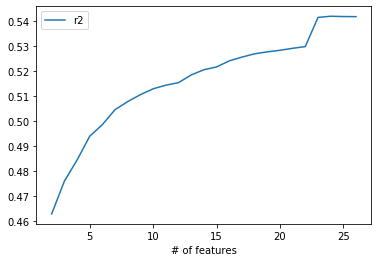

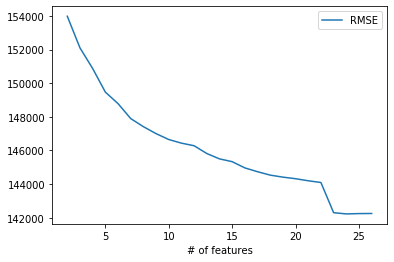

In [17]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
lin_model = LinearRegression() #select model
v=26 #number of features

#feature selection
x=SFS(lin_model,
       k_features=v,
       forward=True,
       scoring='neg_root_mean_squared_error',
       n_jobs=-1,
       cv=3)

x.fit(training, training_labels)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

table =[] #establish table for results

for i in range(2,v+1): #compile statistics on each number of features
    f = list(x.subsets_[i]['feature_names'][0:i])
    lin_model.fit(training[f], training_labels)
    pred = lin_model.predict(testing[f])
    rmse = mean_squared_error(testing_labels, pred, squared = False)
    table.append([i, rmse, r2_score(testing_labels, pred)])
    #print(i)
       
facts = pd.DataFrame(table, columns=['# of features', 'RMSE', 'r2'])

facts.plot('# of features', 'r2')
facts.plot('# of features', 'RMSE')
facts

### Linear Metrics

In [18]:
#Select number of variables which results in lowerst RMSE
i=facts['# of features'].loc[facts['RMSE']==facts['RMSE'].min()].values[0]
#selct which variables are included
f = list(x.subsets_[i]['feature_names'][0:i])

model = lin_model
model.fit(training[f], training_labels)

from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
pd.set_option('display.float_format', lambda x: '%.2f' % x)
estimates = pd.DataFrame(model.predict(testing[f]).reshape(-1,1))
print("median abs error: ", median_absolute_error(testing_labels, estimates))
print("r2: ", r2_score(testing_labels, estimates))
print('mean: ',estimates.mean())
print('rmse: ', mean_squared_error(testing_labels, estimates, squared = False))

median abs error:  39758.421284245065
r2:  0.5418423344718961
mean:  0   177329.23
dtype: float64
rmse:  142225.5412818326


In [19]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
x1 = pd.DataFrame({'names':list(training[f].columns), 'coefs':model.coef_})
home = []
for n,i in enumerate(training[f].columns):
    home.append([i, training[i].mean(), training[i].corr(training_labels), training[i].var(), training[i].std(), 
                 variance_inflation_factor(training[f].values, n)])
x2 = pd.DataFrame(home, columns = ['names', 'mean', 'r2', 'var', 'stdev', 'VIF']).sort_values(by='r2', ascending=False).head(50)

x1.merge(x2,left_on='names', right_on='names')

,names,coefs,mean,r2,var,stdev,VIF
0,finishedsquarefeet12,1299873.48,0.18,0.68,0.01,0.09,6.81
1,heatingorsystemtypeid_2.0,18042.93,0.42,0.15,0.24,0.49,2.40
2,heatingorsystemtypeid_7.0,16152.54,0.24,-0.21,0.18,0.43,1.97
3,no_pool_1,-25478.55,0.80,-0.23,0.16,0.40,4.40
4,garagecarcnt_7+,635779.58,0.00,0.11,0.00,0.01,1.02
5,bathroomcnt_4.0,67946.32,0.05,0.18,0.05,0.21,1.26
6,bathroomcnt_4.5,102302.02,0.01,0.17,0.01,0.08,1.13
7,bathroomcnt_5.0,151446.69,0.01,0.23,0.01,0.12,1.21
8,bathroomcnt_5.5,268042.68,0.00,0.17,0.00,0.05,1.09
9,bathroomcnt_6.0,300800.57,0.01,0.24,0.01,0.08,1.16


In the chart below, I am making sure each P>|t| column or the p values are statistically significant and are under .05. In this case they are all zeros so all is well. 

In [20]:
ols_model = sm.OLS(training_labels, training[f])
ols_results = ols_model.fit()
print(ols_results.summary())

                                     OLS Regression Results                                    
Dep. Variable:     structuretaxvaluedollarcnt   R-squared (uncentered):                   0.728
Model:                                    OLS   Adj. R-squared (uncentered):              0.728
Method:                         Least Squares   F-statistic:                              8913.
Date:                        Wed, 19 Aug 2020   Prob (F-statistic):                        0.00
Time:                                11:13:13   Log-Likelihood:                     -1.0626e+06
No. Observations:                       80000   AIC:                                  2.125e+06
Df Residuals:                           79976   BIC:                                  2.125e+06
Df Model:                                  24                                                  
Covariance Type:                    nonrobust                                                  
                                coef    

# Lasso Regression

,# of features,RMSE,r2,alpha
0,2,153985.93,0.46,0.10
1,3,152102.97,0.48,0.10
2,4,150875.99,0.48,1.00
3,5,149473.89,0.49,0.10
4,6,148788.70,0.50,0.10
5,7,147898.28,0.50,0.10
6,8,147416.14,0.51,0.10
7,9,147001.95,0.51,0.10
8,10,146651.85,0.51,0.10
9,11,146435.92,0.51,0.10


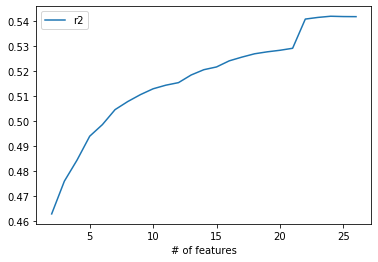

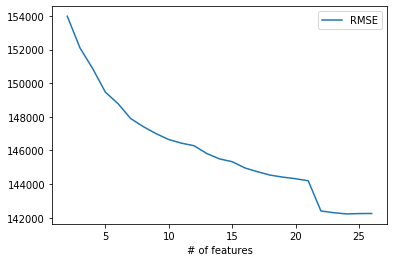

In [21]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
model = Lasso() #select model
v=26 #number of features

#feature selection
x=SFS(model,
       k_features=v,
       forward=True,
       scoring='neg_root_mean_squared_error',
       n_jobs=-1,
       cv=3)

x.fit(training, training_labels)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

table =[] #establish table for results
params = [{'alpha': [64, 4, 1, .1]}] #parameter tuning
for i in range(2,v+1): #compile statistics on each number of features
    f = list(x.subsets_[i]['feature_names'][0:i])
    gridl = GridSearchCV(estimator=model, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)
    gridl.fit(training[f], training_labels)
    pred = gridl.predict(testing[f])
    rmse = mean_squared_error(testing_labels, pred, squared = False)
    table.append([i, rmse, r2_score(testing_labels, pred), gridl.best_estimator_.alpha])
    #print(i)
       
factsl = pd.DataFrame(table, columns=['# of features', 'RMSE', 'r2', 'alpha'])
factsl.plot('# of features', 'r2')
factsl.plot('# of features', 'RMSE')
factsl

### Lasso Metrics

In [22]:
#Select number of variables which results in lowerst RMSE
i=factsl['# of features'].loc[factsl['RMSE']==factsl['RMSE'].min()].values[0]
#selct which variables are included
f = list(x.subsets_[i]['feature_names'][0:i])

model = Lasso()
gridl.fit(training[f], training_labels)

from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
pd.set_option('display.float_format', lambda x: '%.2f' % x)
estimates = pd.DataFrame(gridl.predict(testing[f]).reshape(-1,1))
print("median abs var: ", median_absolute_error(testing_labels, estimates))
print("r2: ", r2_score(testing_labels, estimates))
print('mean: ',estimates.mean())
print('rmse: ', mean_squared_error(testing_labels, estimates, squared = False))

median abs var:  39756.71887388162
r2:  0.5418337432419547
mean:  0   177329.25
dtype: float64
rmse:  142226.87476012245


In [23]:
grid = GridSearchCV(estimator=model, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
grid.fit(training[f], training_labels)
pd.set_option('display.max_rows', None)
np.set_printoptions(suppress=True)
#print(model.coef_)
print('{:.2f}'.format(grid.best_estimator_.intercept_))
x1 = pd.DataFrame({'names':list(training[f].columns), 'coefs':grid.best_estimator_.coef_})

pd.set_option('display.float_format', lambda x: '%.2f' % x)
home = []
for n,i in enumerate(training[f].columns):
    home.append([i, training[i].mean(), training[i].corr(training_labels), training[i].var(), training[i].std(), 
                 variance_inflation_factor(training[f].values, n)])
x2 = pd.DataFrame(home, columns = ['names', 'mean', 'r2', 'var', 'stdev', 'VIF']).sort_values(by='r2', ascending=False).head(50)

x1.merge(x2,left_on='names', right_on='names')

-110890.61


,names,coefs,mean,r2,var,stdev,VIF
0,finishedsquarefeet12,1299886.95,0.18,0.68,0.01,0.09,6.81
1,heatingorsystemtypeid_2.0,18041.72,0.42,0.15,0.24,0.49,2.40
2,heatingorsystemtypeid_7.0,16150.93,0.24,-0.21,0.18,0.43,1.97
3,no_pool_1,-25479.04,0.80,-0.23,0.16,0.40,4.40
4,garagecarcnt_7+,635231.97,0.00,0.11,0.00,0.01,1.02
5,bathroomcnt_4.0,67936.74,0.05,0.18,0.05,0.21,1.26
6,bathroomcnt_4.5,102279.08,0.01,0.17,0.01,0.08,1.13
7,bathroomcnt_5.0,151429.38,0.01,0.23,0.01,0.12,1.21
8,bathroomcnt_5.5,267984.67,0.00,0.17,0.00,0.05,1.09
9,bathroomcnt_6.0,300772.37,0.01,0.24,0.01,0.08,1.16


# Ridge Regression

In [24]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
model = Ridge() #select model
v=26 #number of features

#feature selection
x=SFS(model,
       k_features=v,
       forward=True,
       scoring='neg_root_mean_squared_error',
       n_jobs=-1,
       cv=3)

x.fit(training, training_labels)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

table =[] #establish table for results
params = [{'alpha': [10, 1,.1, .01]}] #parameter tuning
for i in range(2,v+1): #compile statistics on each number of features
    f = list(x.subsets_[i]['feature_names'][0:i])
    gridr = GridSearchCV(estimator=model, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)
    gridr.fit(training[f], training_labels)
    pred = gridr.predict(testing[f])
    rmse = mean_squared_error(testing_labels, pred, squared = False)
    table.append([i, rmse, r2_score(testing_labels, pred), gridr.best_estimator_.alpha])
       
factsr = pd.DataFrame(table, columns=['# of features', 'RMSE', 'r2', 'alpha'])
factsr

,# of features,RMSE,r2,alpha
0,2,153985.93,0.46,0.01
1,3,152102.98,0.48,0.01
2,4,150876.02,0.48,0.01
3,5,149473.87,0.49,0.01
4,6,148788.67,0.50,0.01
5,7,147898.22,0.50,0.01
6,8,147416.09,0.51,0.01
7,9,147001.90,0.51,0.01
8,10,146651.80,0.51,0.01
9,11,146435.88,0.51,0.01


### Ridge Regression metrics

In [25]:
#Select number of variables which results in lowerst RMSE
i=factsr['# of features'].loc[factsr['RMSE']==factsr['RMSE'].min()].values[0]
#selct which variables are included
f = list(x.subsets_[i]['feature_names'][0:i])

model = Ridge()
gridr.fit(training[f], training_labels)

from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
pd.set_option('display.float_format', lambda x: '%.2f' % x)
estimates = pd.DataFrame(gridr.predict(testing[f]).reshape(-1,1))
print("median abs var: ", median_absolute_error(testing_labels, estimates))
print("r2: ", r2_score(testing_labels, estimates))
print('mean: ',estimates.mean())
print('rmse: ', mean_squared_error(testing_labels, estimates, squared = False))

median abs var:  39717.16045679635
r2:  0.5414516039722266
mean:  0   177327.94
dtype: float64
rmse:  142286.1754452519


In [26]:
grid = GridSearchCV(estimator=model, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)
grid.fit(training[f], training_labels)
pd.set_option('display.max_rows', None)
np.set_printoptions(suppress=True)
#print(model.coef_)
print('{:.2f}'.format(grid.best_estimator_.intercept_))
x1 = pd.DataFrame({'names':list(training[f].columns), 'coefs':grid.best_estimator_.coef_})

pd.set_option('display.float_format', lambda x: '%.2f' % x)
home = []
for n,i in enumerate(training[f].columns):
    home.append([i, training[i].mean(), training[i].corr(training_labels), training[i].var(), training[i].std(), 
                 variance_inflation_factor(training[f].values, n)])
x2 = pd.DataFrame(home, columns = ['names', 'mean', 'r2', 'var', 'stdev', 'VIF']).sort_values(by='r2', ascending=False).head(50)

x1.merge(x2,left_on='names', right_on='names')

-109798.38


,names,coefs,mean,r2,var,stdev,VIF
0,finishedsquarefeet12,1296443.08,0.18,0.68,0.01,0.09,6.81
1,heatingorsystemtypeid_2.0,18031.70,0.42,0.15,0.24,0.49,2.40
2,heatingorsystemtypeid_7.0,16075.37,0.24,-0.21,0.18,0.43,1.97
3,no_pool_1,-25663.60,0.80,-0.23,0.16,0.40,4.40
4,garagecarcnt_7+,594735.98,0.00,0.11,0.00,0.01,1.02
5,bathroomcnt_4.0,67984.41,0.05,0.18,0.05,0.21,1.26
6,bathroomcnt_4.5,102527.92,0.01,0.17,0.01,0.08,1.13
7,bathroomcnt_5.0,151591.42,0.01,0.23,0.01,0.12,1.21
8,bathroomcnt_5.5,267063.05,0.00,0.17,0.00,0.05,1.09
9,bathroomcnt_6.0,300716.91,0.01,0.24,0.01,0.08,1.16


# Visualizations

,# of features,RMSE,r2,alpha
0,2,153985.93,0.46,0.01
1,3,152102.98,0.48,0.01
2,4,150876.02,0.48,0.01
3,5,149473.87,0.49,0.01
4,6,148788.67,0.50,0.01
5,7,147898.22,0.50,0.01
6,8,147416.09,0.51,0.01
7,9,147001.90,0.51,0.01
8,10,146651.80,0.51,0.01
9,11,146435.88,0.51,0.01


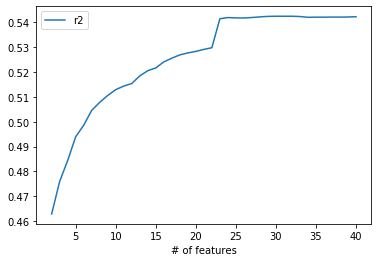

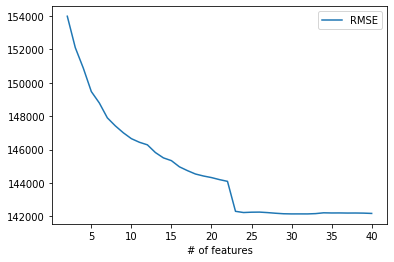

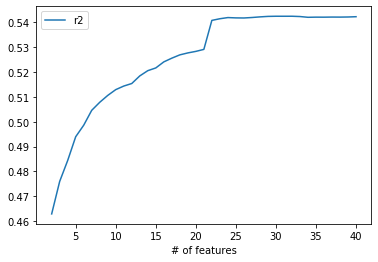

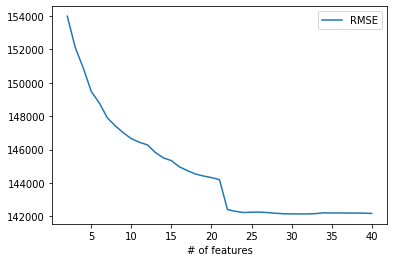

In [27]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
lin_model = LinearRegression() #select model
v=40 #number of features

#feature selection
x=SFS(lin_model,
       k_features=v,
       forward=True,
       scoring='neg_root_mean_squared_error',
       n_jobs=-1,
       cv=3)

x.fit(training, training_labels)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

table =[] #establish table for results

for i in range(2,v+1): #compile statistics on each number of features
    f = list(x.subsets_[i]['feature_names'][0:i])
    lin_model.fit(training[f], training_labels)
    pred = lin_model.predict(testing[f])
    rmse = mean_squared_error(testing_labels, pred, squared = False)
    table.append([i, rmse, r2_score(testing_labels, pred)])
    #print(i)
       
facts = pd.DataFrame(table, columns=['# of features', 'RMSE', 'r2'])

facts.plot('# of features', 'r2')
facts.plot('# of features', 'RMSE')
facts

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
model = Lasso() #select model

#feature selection
x=SFS(model,
       k_features=v,
       forward=True,
       scoring='neg_root_mean_squared_error',
       n_jobs=-1,
       cv=3)

x.fit(training, training_labels)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

table =[] #establish table for results
params = [{'alpha': [64, 4, 1, .1]}] #parameter tuning
for i in range(2,v+1): #compile statistics on each number of features
    f = list(x.subsets_[i]['feature_names'][0:i])
    gridl = GridSearchCV(estimator=model, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)
    gridl.fit(training[f], training_labels)
    pred = gridl.predict(testing[f])
    rmse = mean_squared_error(testing_labels, pred, squared = False)
    table.append([i, rmse, r2_score(testing_labels, pred), gridl.best_estimator_.alpha])
    #print(i)
       
factsl = pd.DataFrame(table, columns=['# of features', 'RMSE', 'r2', 'alpha'])
factsl.plot('# of features', 'r2')
factsl.plot('# of features', 'RMSE')
factsl

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
model = Ridge() #select model

#feature selection
x=SFS(model,
       k_features=v,
       forward=True,
       scoring='neg_root_mean_squared_error',
       n_jobs=-1,
       cv=3)

x.fit(training, training_labels)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

table =[] #establish table for results
params = [{'alpha': [10, 1,.1, .01]}] #parameter tuning
for i in range(2,v+1): #compile statistics on each number of features
    f = list(x.subsets_[i]['feature_names'][0:i])
    gridr = GridSearchCV(estimator=model, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)
    gridr.fit(training[f], training_labels)
    pred = gridr.predict(testing[f])
    rmse = mean_squared_error(testing_labels, pred, squared = False)
    table.append([i, rmse, r2_score(testing_labels, pred), gridr.best_estimator_.alpha])
    #print(i)
       
factsr = pd.DataFrame(table, columns=['# of features', 'RMSE', 'r2', 'alpha'])
factsr

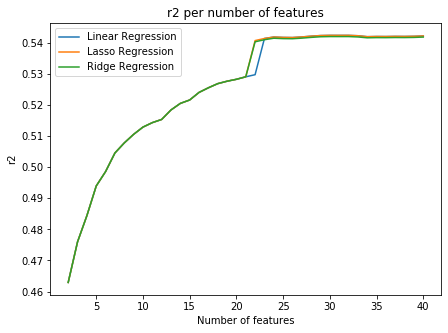

In [28]:
plt.figure(figsize=(7, 5))
plt.plot(facts['# of features'], facts['r2'], label = 'Linear Regression')
plt.plot(factsl['# of features'], factsl['r2'], label = 'Lasso Regression')
plt.plot(factsr['# of features'], factsr['r2'], label = 'Ridge Regression')
plt.xlabel('Number of features')
plt.ylabel('r2')
plt.title('r2 per number of features')
plt.legend()
plt.savefig('structure_r2.png')

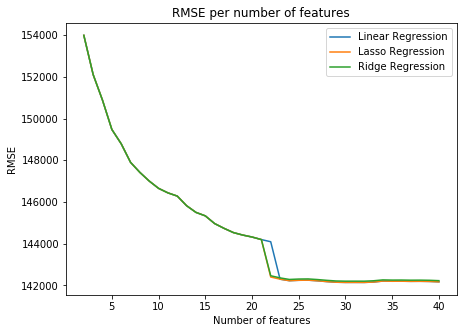

In [29]:
plt.figure(figsize=(7, 5))
plt.plot(facts['# of features'], facts['RMSE'], label = 'Linear Regression')
plt.plot(factsl['# of features'], factsl['RMSE'], label = 'Lasso Regression')
plt.plot(factsr['# of features'], factsr['RMSE'], label = 'Ridge Regression')
plt.xlabel('Number of features')
plt.ylabel('RMSE')
plt.title('RMSE per number of features')
plt.legend()
plt.savefig('structure_RMSE.png')

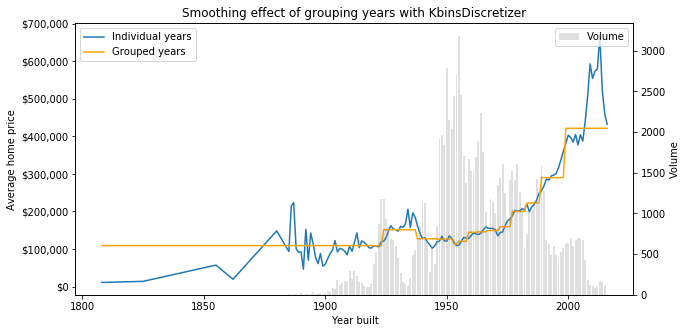

In [30]:
import matplotlib.ticker as ticker
housing2 = housing[['yearbuilt', 'structuretaxvaluedollarcnt']]

#strategy{‘uniform’, ‘quantile’, ‘kmeans’}, (default=’quantile’)
binned_cat_pipeline = Pipeline([
    ('kbins', KbinsTransformer(bins = 15, fillval= housing.yearbuilt.median(), encode='ordinal', strategy='quantile')),
    ])

pre_pipeline = ColumnTransformer([
    ("kbin_cat", binned_cat_pipeline, binned_cats), 
    ])

housing2['k_years'] = pre_pipeline.fit_transform(housing)

import matplotlib.ticker as mtick
grouped = pd.DataFrame(housing2.groupby(['yearbuilt', 'k_years']).agg(
    price_year= pd.NamedAgg(column='structuretaxvaluedollarcnt', aggfunc= 'mean'),
    count_year= pd.NamedAgg(column='structuretaxvaluedollarcnt', aggfunc='count')
    )).reset_index()

df = pd.DataFrame(housing2.groupby('k_years')['structuretaxvaluedollarcnt'].mean()).reset_index()
grouped = grouped.merge(df,left_on='k_years', right_on='k_years')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
grouped.plot(x='yearbuilt', y='price_year', ax=ax, label = 'Individual years')
grouped.plot(x='yearbuilt', y='structuretaxvaluedollarcnt', ax=ax, label = 'Grouped years', color = 'orange')
#grouped['count_year'].plot(x='yearbuilt', y='count_year', ax=ax, label = 'Volume years')

ax2 = ax.twinx()
ax2.set_ylabel('Volume')
ax2.bar(grouped['yearbuilt'], grouped['count_year'], color='grey', alpha=.25, label = 'Volume')
ax2.tick_params(axis='y')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)
plt.legend()
ax.set_xlabel('Year built')
ax.set_ylabel('Average home price', )
plt.title('Smoothing effect of grouping years with KbinsDiscretizer')
plt.savefig('structure_year_blend.png')